In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3,4'
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'

In [2]:
import sentence_transformers
from sentence_transformers import SentenceTransformer

/home/ionov/anaconda3/envs/kaggle/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
from sklearn.cluster import KMeans

In [3]:
import pandas as pd
import numpy as np

In [4]:
import random
from collections import defaultdict, Counter

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df = pd.read_csv('../data/yappy_hackaton_2024_400k.csv')
# df = pd.read_csv('../data/yappy_preprocessed_400k.csv')

In [7]:
import re
def extract_text_and_hashtags(description):
    description = description.replace(',', '')
    hashtags = re.findall(r'#\w+', description)
    clean_text = re.sub(r'#\w+', '', description).strip()
    tags = [h.replace('#', "") for h in hashtags]
    
    return " ".join(tags), clean_text, tags

In [8]:
df['description'] = df['description'].fillna('')
df[['raw_tags', 'clean_text', 'hashtags']] = df['description'].apply(lambda x: pd.Series(extract_text_and_hashtags(x)))

df['num_hashtags'] = df['hashtags'].apply(len)
df['text_length'] = df['clean_text'].apply(len)

df['has_text'] = df['clean_text'].apply(lambda x: bool(x.strip()))
df['has_hashtags'] = df['num_hashtags'] > 0

In [11]:
model = SentenceTransformer('intfloat/multilingual-e5-base')

In [12]:
embeddings = model.encode(df['raw_tags'].tolist(), batch_size=128, show_progress_bar=True)

Batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3125/3125 [04:05<00:00, 12.72it/s]


In [13]:
embeddings.shape

(400000, 768)

In [17]:
num_clusters = 20
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
labels = kmeans.fit_predict(embeddings)

In [65]:
cluster_samples = 1000

In [19]:
df['cluster'] = labels

In [66]:
sampled_indices = []
for cluster in range(num_clusters):
    cluster_indices = df[(df['cluster'] == cluster) & (df['num_hashtags'] < 7) & (df['num_hashtags'] > 2)].index.tolist()
    sampled_indices.extend(random.sample(cluster_indices, min(cluster_samples, len(cluster_indices))))

In [67]:
sampled_df = df.loc[sampled_indices].reset_index(drop=True)

In [68]:
sampled_df.shape

(13094, 10)

In [69]:
sampled_df.to_csv('../data/13k_selected.csv', index=False)

In [70]:
!pip install wordcloud

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 kB 5.1 MB/s eta 0:00:00 MB/s eta 0:00:0101


In [72]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [77]:
cluster_hashtags = defaultdict(list)
for idx, row in df.iterrows():
    cluster_hashtags[row['cluster']].extend(row['hashtags'])

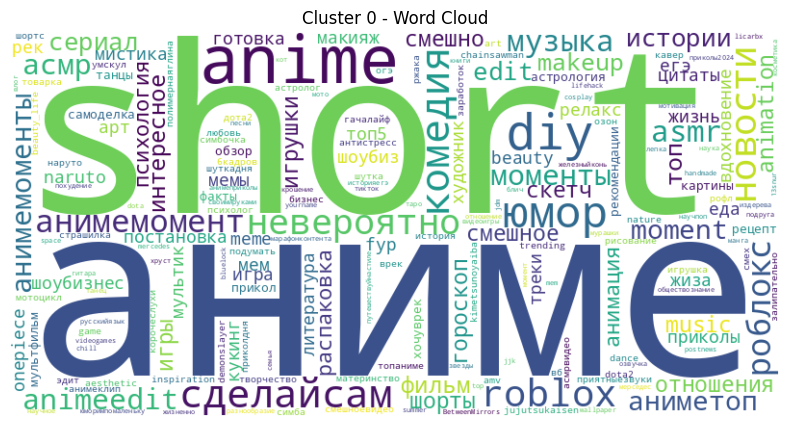

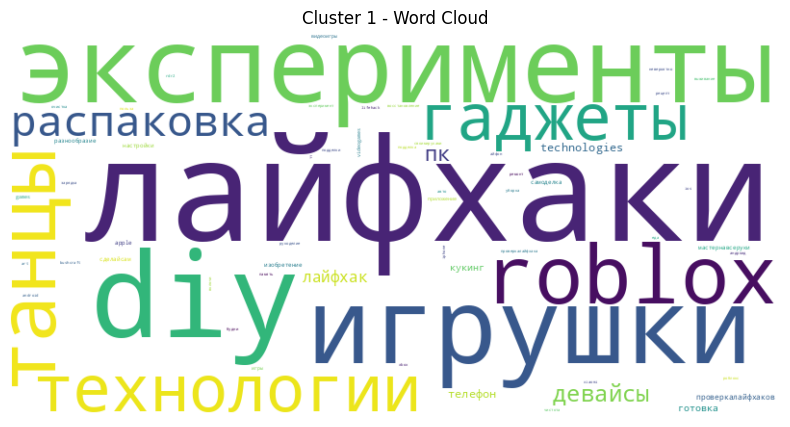

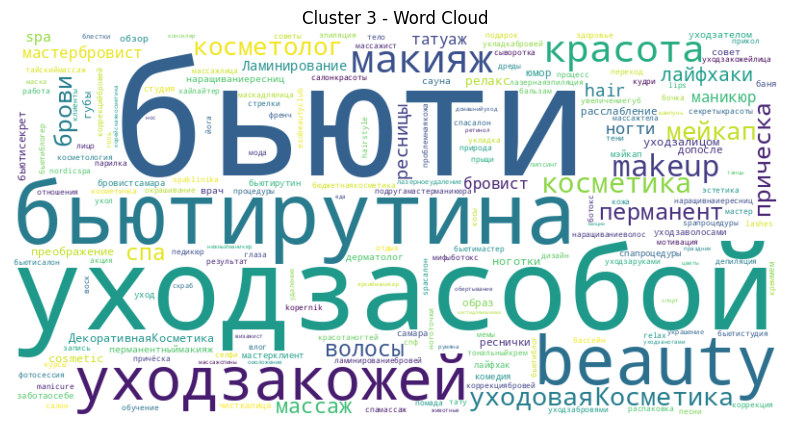

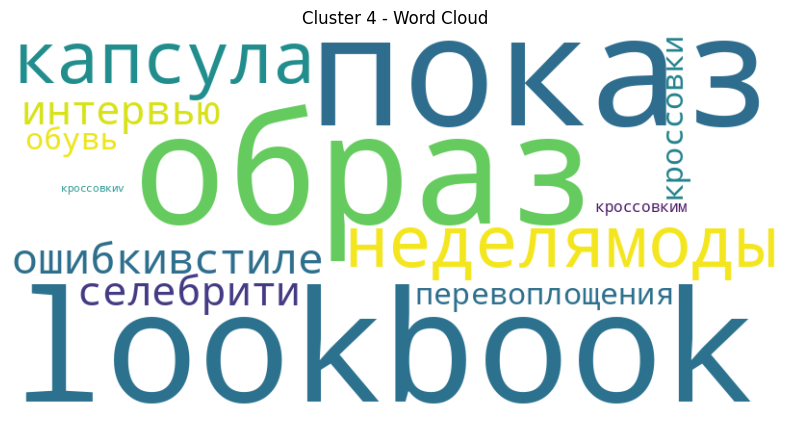

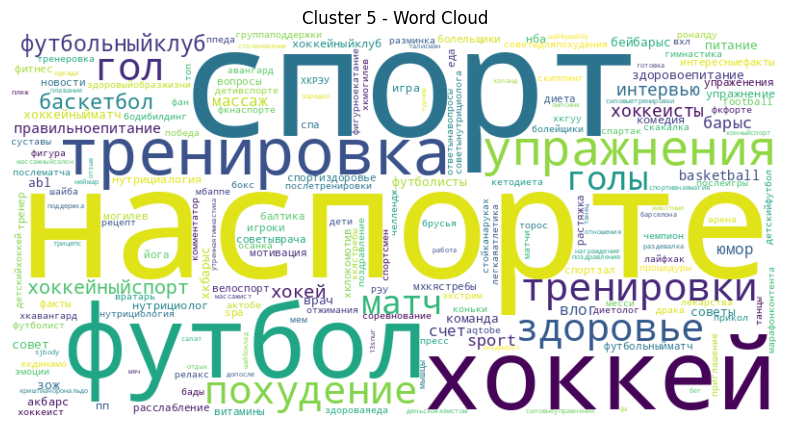

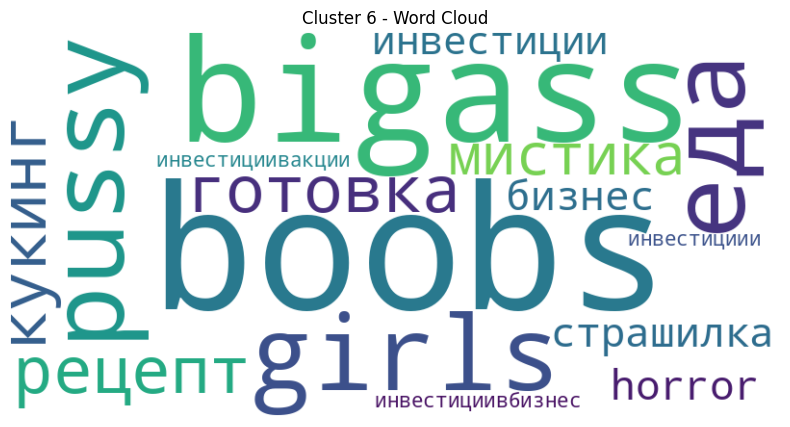

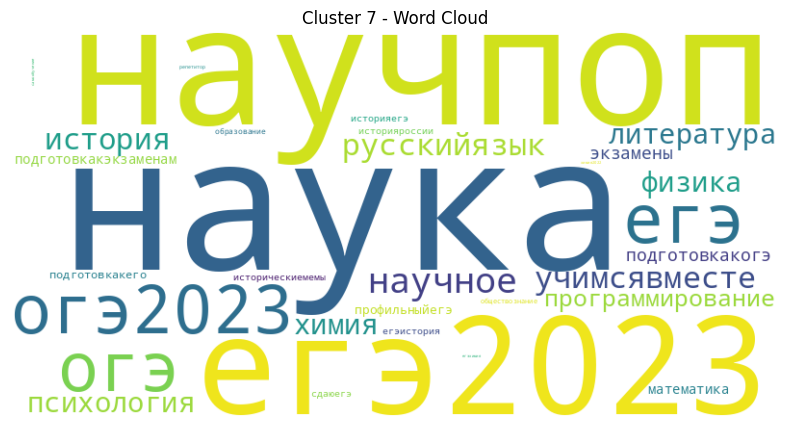

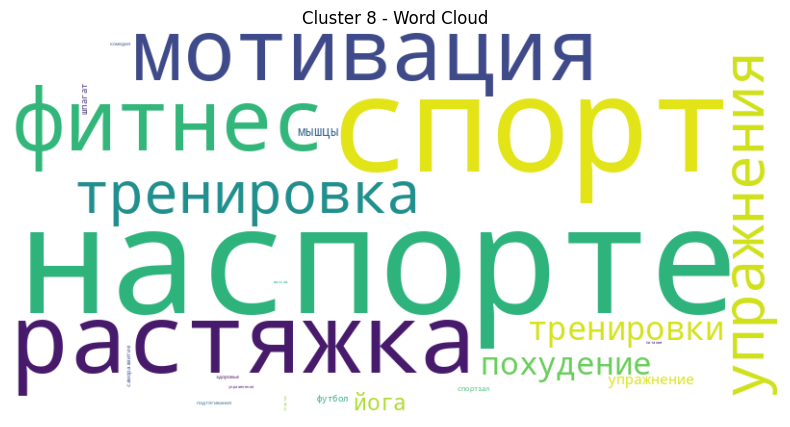

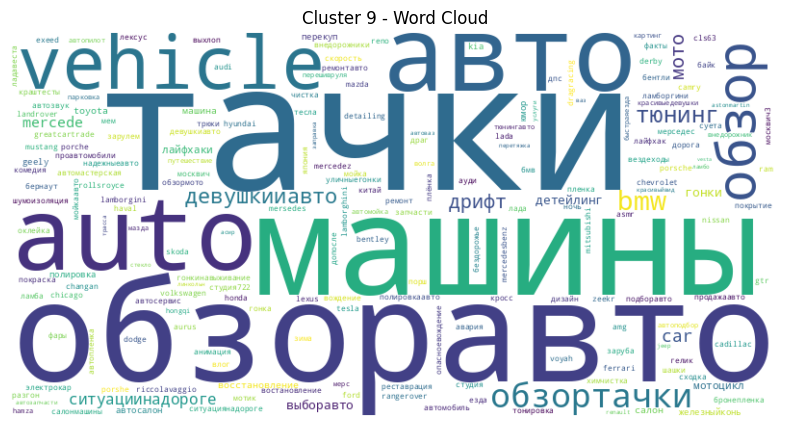

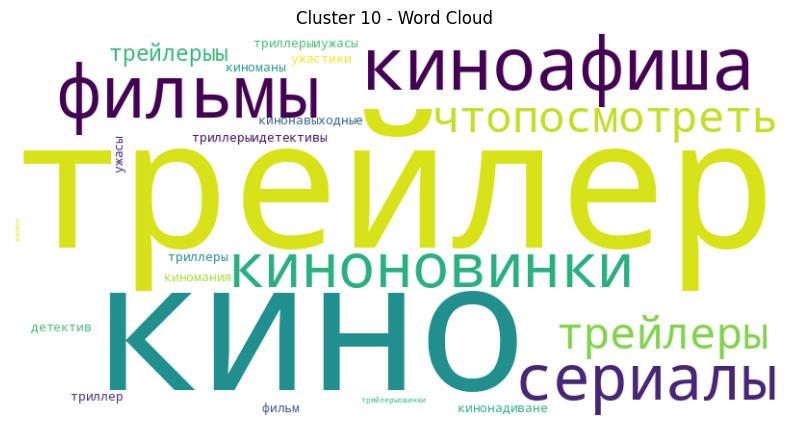

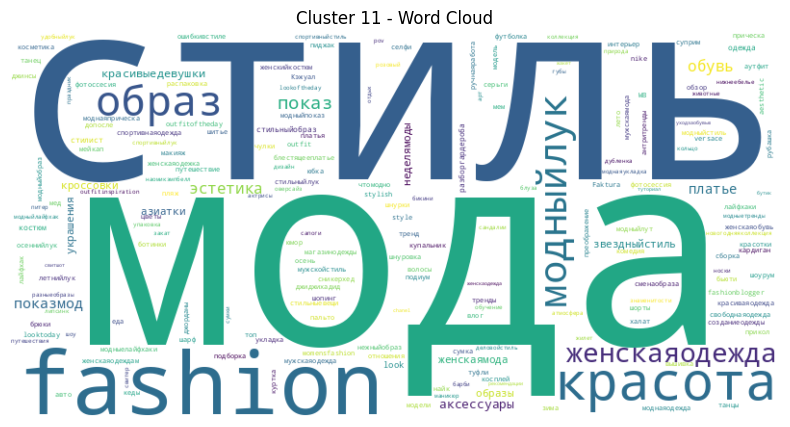

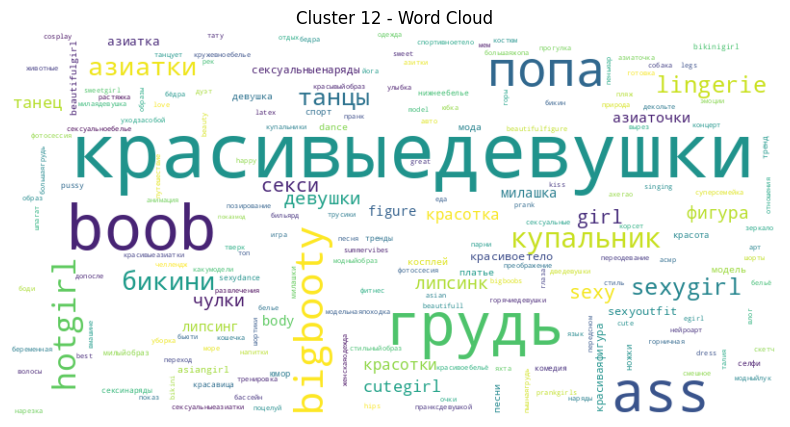

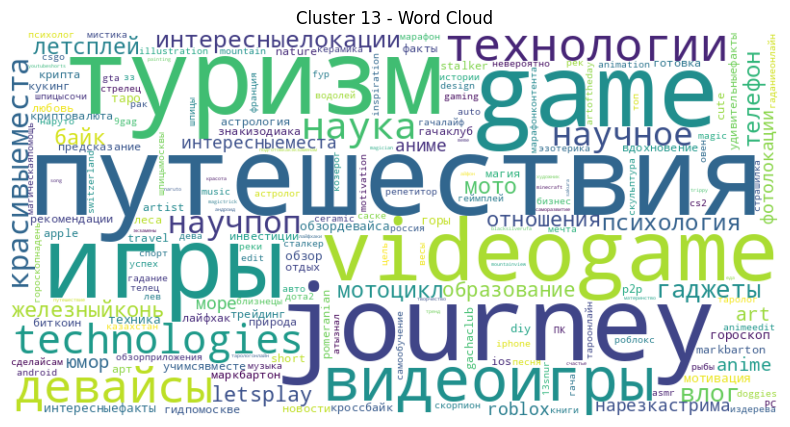

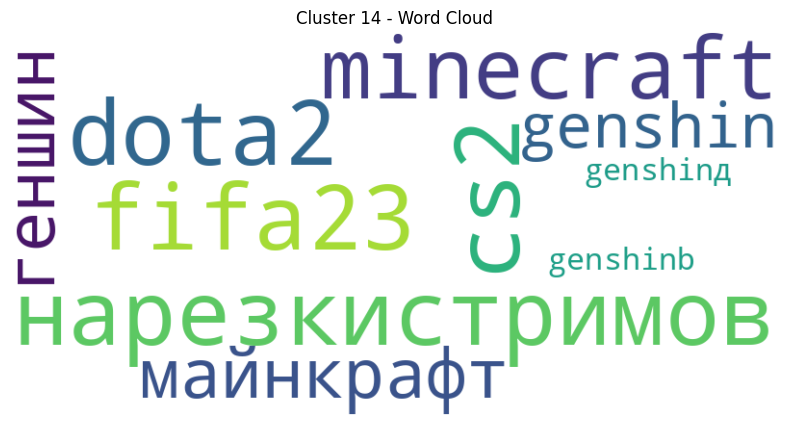

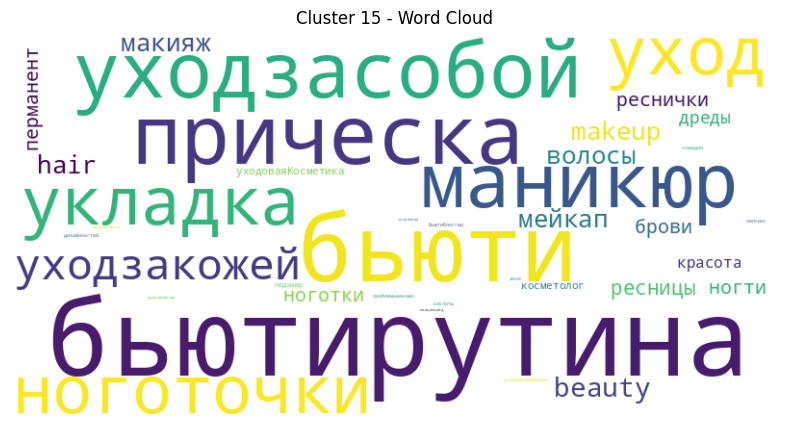

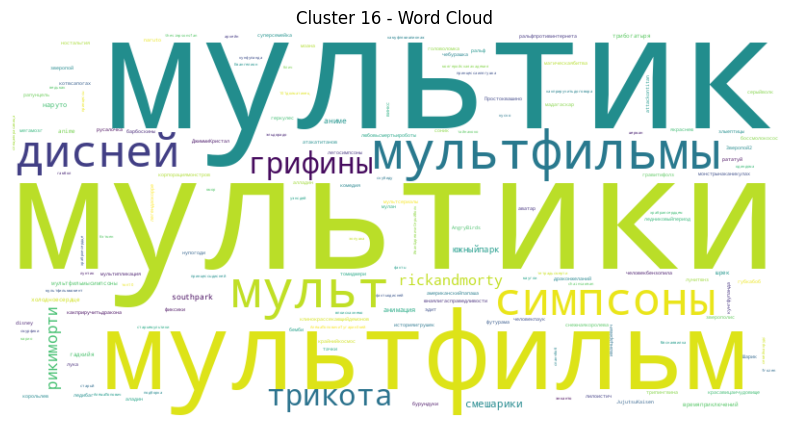

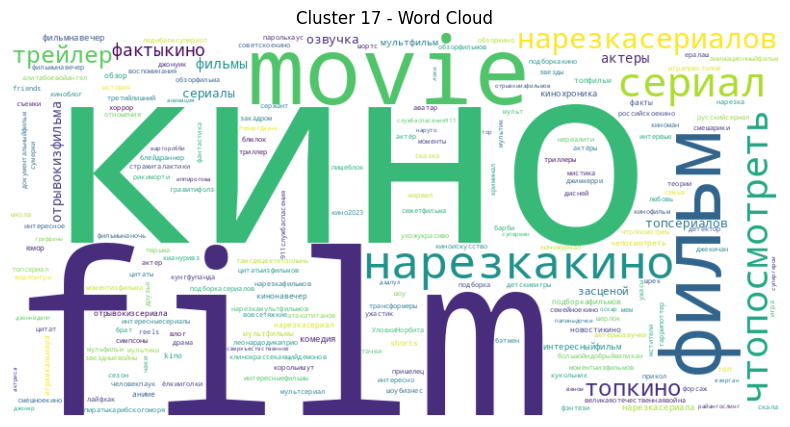

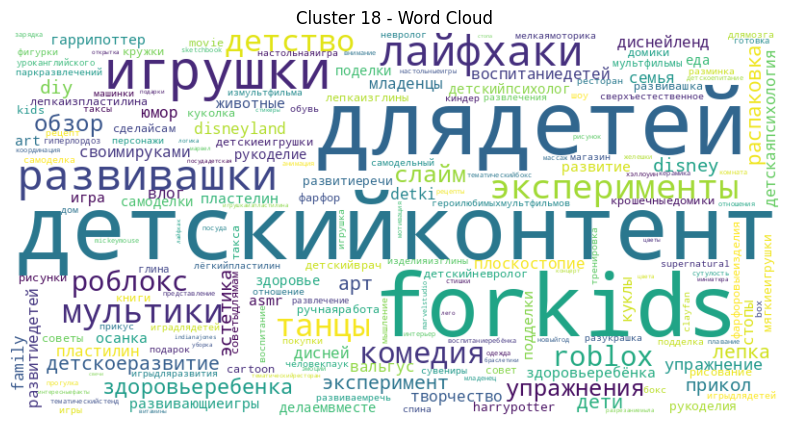

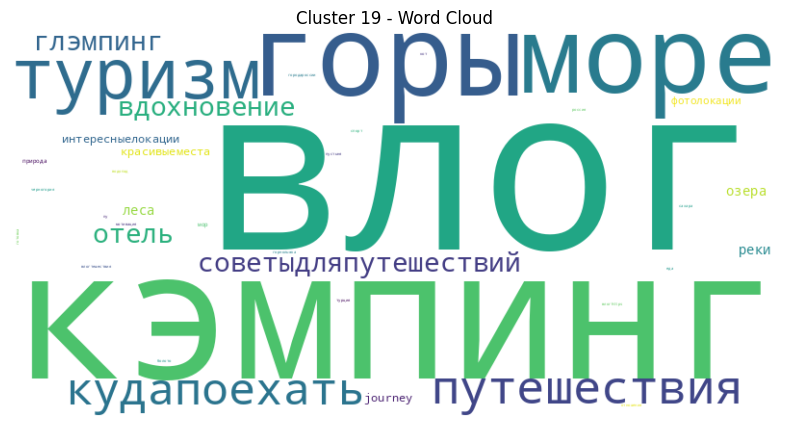

In [78]:
for cluster in range(num_clusters):
    words = ' '.join(cluster_hashtags[cluster])
    if not words:
        continue
    wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Cluster {cluster} - Word Cloud')
    plt.savefig(f'../assets/word_clouds/cluster_{cluster}.png')
    plt.show()

In [10]:
all_tags = [tag for sublist in df['hashtags'] for tag in sublist]
tag_counts = Counter(all_tags)

tag_to_indices = defaultdict(list)
for idx, tags in enumerate(df['hashtags']):
    for tag in tags:
        tag_to_indices[tag].append(idx)

In [11]:
sampled_indices = set()
sampled_tags = set()
target_sample_size = 20000

while len(sampled_indices) < target_sample_size:
    for tag, indices in sorted(tag_to_indices.items(), key=lambda item: tag_counts[item[0]], reverse=True):
        if len(sampled_indices) >= target_sample_size:
            break
        random.shuffle(indices)
        for idx in indices:
            if idx not in sampled_indices:
                sampled_indices.add(idx)
                sampled_tags.update(df['hashtags'][idx])
                if len(sampled_indices) >= target_sample_size:
                    break

In [12]:
sampled_df = df.loc[list(sampled_indices)].reset_index(drop=True)

In [33]:
sampled_df.sample(100)

link  \
13400  https://cdn-st.rutubelist.ru/media/66/10/3cc95...   
12774  https://cdn-st.rutubelist.ru/media/2e/30/89c46...   
18783  https://cdn-st.rutubelist.ru/media/7d/6b/70c8a...   
8341   https://cdn-st.rutubelist.ru/media/ef/4d/eb5a1...   
7434   https://cdn-st.rutubelist.ru/media/ec/c1/d3a8f...   
...                                                  ...   
12336  https://cdn-st.rutubelist.ru/media/30/ac/ed8ed...   
3537   https://cdn-st.rutubelist.ru/media/21/a8/d0b94...   
3314   https://cdn-st.rutubelist.ru/media/15/64/d297e...   
15174  https://cdn-st.rutubelist.ru/media/ab/7b/72dd6...   
5838   https://cdn-st.rutubelist.ru/media/96/bf/c50cb...   

                                             description clean_text  \
13400  #красивыедевушки #красотка #секси #попа #ass #...              
12774                   #boobs , #красивыедевушки , #ass              
18783                   #boobs , #красивыедевушки , #ass              
8341              #красивыедевушки #грудь #boobs #бикини              
7434   #красивыедевушки #грудь #попа #ass #girl #hotg...              
...                                                  ...        ...   
12336                         #красивыедевушки #bigbooty              
3537   #красивыедевушки #милашка #девушка #грудь #boo...              
3314             #красивыедевушки #грудь #boobs #липсинк              
15174  #красивыедевушки #cutegirls #sexygirls  #грудь...              
5838       #красивыедевушки #грудь #boobs #бикини #танцы              

                                                hashtags  num_hashtags  \
13400  [красивыедевушки, красотка, секси, попа, ass, ...             7   
12774                      [boobs, красивыедевушки, ass]             3   
18783                      [boobs, красивыедевушки, ass]             3   
8341             [красивыедевушки, грудь, boobs, бикини]             4   
7434   [красивыедевушки, грудь, попа, ass, girl, hotg...             7   
...                                                  ...           ...   
12336                        [красивыедевушки, bigbooty]             2   
3537   [красивыедевушки, милашка, девушка, грудь, boo...            10   
3314            [красивыедевушки, грудь, boobs, липсинк]             4   
15174  [красивыедевушки, cutegirls, sexygirls, грудь,...             8   
5838      [красивыедевушки, грудь, boobs, бикини, танцы]             5   

       text_length  has_text  has_hashtags  
13400            0     False          True  
12774            0     False          True  
18783            0     False          True  
8341             0     False          True  
7434             0     False          True  
...            ...       ...           ...  
12336            0     False          True  
3537             0     False          True  
3314             0     False          True  
15174            0     False          True  
5838             0     False          True  

[100 rows x 8 columns]

In [14]:
df = sampled_df

In [15]:
df['has_hashtags'].value_counts(1)

has_hashtags
True    1.0
Name: proportion, dtype: float64

In [16]:
df['has_text'].value_counts(1)

has_text
False    0.9994
True     0.0006
Name: proportion, dtype: float64

In [17]:
df.describe()

num_hashtags   text_length
count  20000.000000  20000.000000
mean       4.757500      0.000700
std        1.961144      0.031616
min        1.000000      0.000000
25%        3.000000      0.000000
50%        4.000000      0.000000
75%        6.000000      0.000000
max       15.000000      3.000000

In [18]:
df[df.has_text][['text_length']].describe()

text_length
count    12.000000
mean      1.166667
std       0.577350
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       3.000000

In [19]:
df.sample(10)

link  \
4251   https://cdn-st.rutubelist.ru/media/37/0c/e2d4e...   
5957   https://cdn-st.rutubelist.ru/media/7f/5f/a76ea...   
1888   https://cdn-st.rutubelist.ru/media/a3/60/062af...   
18377  https://cdn-st.rutubelist.ru/media/66/0f/175ef...   
8057   https://cdn-st.rutubelist.ru/media/41/38/5ce7e...   
3556   https://cdn-st.rutubelist.ru/media/7d/58/fca04...   
2071   https://cdn-st.rutubelist.ru/media/0e/67/f09c0...   
17516  https://cdn-st.rutubelist.ru/media/28/0a/36555...   
7303   https://cdn-st.rutubelist.ru/media/d4/e0/a3ee7...   
6594   https://cdn-st.rutubelist.ru/media/35/b3/5d9e7...   

                                             description clean_text  \
4251                   #красивыедевушки #bigbooty #грудь              
5957                #красивыедевушки #азиатки #попа #ass              
1888           #красивыедевушки #грудь #boobs #попа #ass              
18377   #красивыедевушки #грудь #boobs #попа #ass #pussy              
8057            #красивыедевушки #бикини #boobs #липсинк              
3556   #красивыедевушки #cutegirls #sexygirls #грудь ...              
2071   #красивыедевушки #азиатка #красавица #asiangir...              
17516  #красивыедевушки #hotgirl #липсинг #грудь #boo...              
7303         #красивыедевушки\n\n#грудь #boobs #красотка              
6594                     #красивыедевушки  #грудь #boobs              

                                                hashtags  num_hashtags  \
4251                  [красивыедевушки, bigbooty, грудь]             3   
5957               [красивыедевушки, азиатки, попа, ass]             4   
1888          [красивыедевушки, грудь, boobs, попа, ass]             5   
18377  [красивыедевушки, грудь, boobs, попа, ass, pussy]             6   
8057           [красивыедевушки, бикини, boobs, липсинк]             4   
3556   [красивыедевушки, cutegirls, sexygirls, грудь,...             8   
2071   [красивыедевушки, азиатка, красавица, asiangir...             5   
17516  [красивыедевушки, hotgirl, липсинг, грудь, boo...             6   
7303           [красивыедевушки, грудь, boobs, красотка]             4   
6594                     [красивыедевушки, грудь, boobs]             3   

       text_length  has_text  has_hashtags  
4251             0     False          True  
5957             0     False          True  
1888             0     False          True  
18377            0     False          True  
8057             0     False          True  
3556             0     False          True  
2071             0     False          True  
17516            0     False          True  
7303             0     False          True  
6594             0     False          True

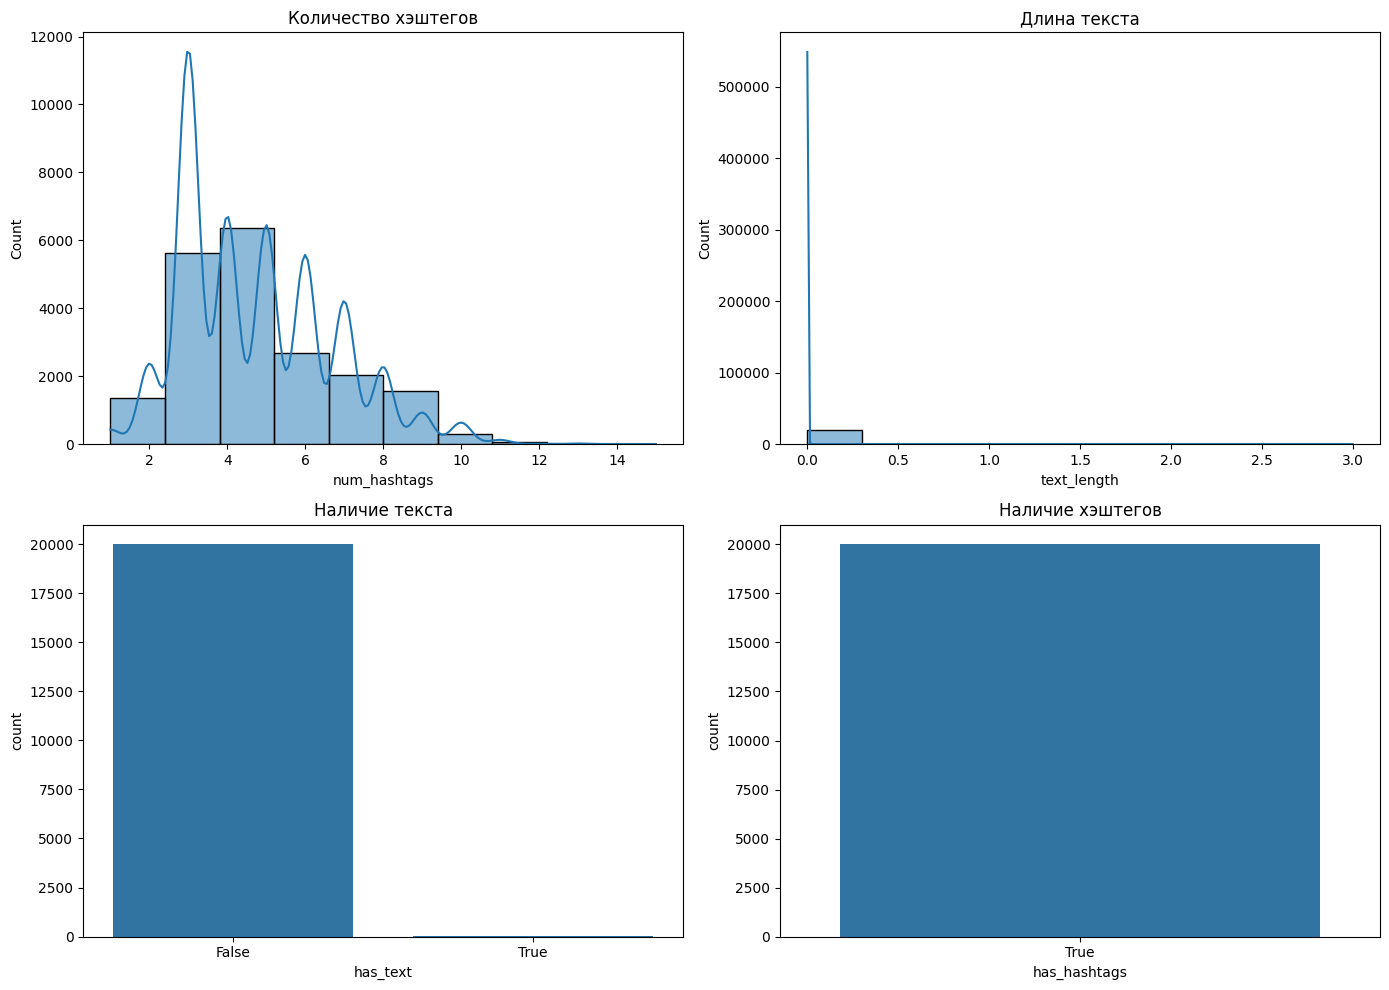

In [20]:
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sns.histplot(df['num_hashtags'], bins=10, kde=True)
plt.title('Количество хэштегов')

plt.subplot(2, 2, 2)
sns.histplot(df['text_length'], bins=10, kde=True)
plt.title('Длина текста')

plt.subplot(2, 2, 3)
sns.countplot(x='has_text', data=df)
plt.title('Наличие текста')

plt.subplot(2, 2, 4)
sns.countplot(x='has_hashtags', data=df)
plt.title('Наличие хэштегов')

plt.tight_layout()
plt.show()

In [21]:
all_tags = list(tag for sublist in df['hashtags'] for tag in sublist)

In [22]:
len(all_tags)

95150

In [23]:
unique_tags = set(all_tags)

In [24]:
len(unique_tags)

643

In [25]:
len(unique_tags) / len(all_tags)

0.006757750919600631

In [32]:
from collections import Counter


In [33]:
tag_counts = Counter(all_tags)

In [34]:
len(unique_tags)

632

In [35]:
tag_counts.most_common(15)

[('красивыедевушки', 20003),
 ('boobs', 12797),
 ('грудь', 11638),
 ('ass', 9581),
 ('попа', 7381),
 ('bigbooty', 4517),
 ('hotgirl', 2481),
 ('купальник', 2044),
 ('азиатки', 1926),
 ('бикини', 1696),
 ('танцы', 1469),
 ('lingerie', 1429),
 ('sexy', 872),
 ('sexygirls', 804),
 ('секси', 785)]

In [25]:
38798 + 37669 + 22795 + 18794

118056

In [36]:
import networkx as nx
from community import community_louvain

In [37]:
unique_tags = list(set(all_tags))

In [38]:
co_occurrence_matrix = np.zeros((len(unique_tags), len(unique_tags)))

In [39]:
tag_to_index = {tag: idx for idx, tag in enumerate(unique_tags)}

In [40]:
for tags in df['hashtags']:
    for i in range(len(tags)):
        for j in range(i + 1, len(tags)):
            idx_i = tag_to_index[tags[i]]
            idx_j = tag_to_index[tags[j]]
            co_occurrence_matrix[idx_i, idx_j] += 1
            co_occurrence_matrix[idx_j, idx_i] += 1

In [41]:
G = nx.from_numpy_array(co_occurrence_matrix)

In [42]:
partition = community_louvain.best_partition(G)

In [43]:
clusters = defaultdict(list)
for tag, cluster_id in partition.items():
    clusters[cluster_id].append(unique_tags[tag])

In [44]:
len(clusters)

19

In [45]:
for cluster_id, tags in clusters.items():
    print(f'Cluster {cluster_id}: {tags[:20]}')

Cluster 0: ['удивительное', 'интересное']
Cluster 1: ['getdressedwithme', 'чистказубов', 'азиато', 'смешное', 'ресницы', 'ass', 'dress', 'clap', 'животные', 'спортзал', 'платьясетка', 'тренировки', 'мода', 'барби', 'рубашка', 'технологии', 'аниме', 'фитнес', 'спорт', 'красивыйкомплект']
Cluster 2: ['туризм', 'journey', 'мотивация', 'путешествия']
Cluster 3: ['природа', 'бокс', 'Красивыедевушки', 'уходзасобой', 'красавица', 'хеллоуин', 'mercedes', 'гольфы', 'hongqi', 'детектор', 'когдаонсдругой', 'красота', 'фотоссесия', 'sport', 'тусовка', 'футбол', 'красивыеволосы', 'какумодели', 'бельё', 'прекраснаяулыбка']
Cluster 4: ['сексуальныеазиатки', 'сексуальные', 'красивыеазиатки', 'азитки']
Cluster 5: ['локоны', 'обзор', 'увлечениехобби', 'catgirl', 'sexyoutfit', 'сексуальныенаряды', 'нижнеебельё', 'cosplayergirl', 'аппарат', 'fitgirl', 'чулочки', 'глазки', 'красивоебельё', 'бедра', 'куппальник', 'горячиедевушки', 'prankgirls', 'звездныевойны', 'sweet', 'pov']
Cluster 6: ['милая', 'азитка',

In [37]:
df.shape

(181506, 8)

In [38]:
df.sample(15_000).to_csv('../data/20k_selected.csv', index=False)